In [ ]:
import pandas as pd
import nibabel as nib
import numpy as np
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

Download the phenotypic data and place it under 'metadata' folder

Refer to phenotypic data dictionary here: http://fcon_1000.projects.nitrc.org/indi/abide/ABIDE_LEGEND_V1.02.pdf

http://fcon_1000.projects.nitrc.org/indi/abide/ABIDEII_Data_Legend.pdf

In [ ]:
metadata_path = Path("./ABIDE/data/metadata")
rawdataBIDS_path = Path("./ABIDE/RawDataBIDS")
sidecar_path = Path("./ABIDE/RawDataBIDS/sidecards")

In [ ]:
sites = [f for f in rawdataBIDS_path.iterdir() if f.is_dir() and "sidecards" not in f.name]
print(f"Scanning {len(sites)} sites in {rawdataBIDS_path}...")

Scanning 24 sites in ABIDE/RawDataBIDS...


In [ ]:
data = {}
for site_path in sites:
    site_name = site_path.name

    # 2. Get all Subject Folders in this site (starting with 'sub-')
    subjects = [s for s in site_path.iterdir() if s.is_dir() and s.name.startswith('sub-')]

    for sub_path in subjects:
        sub_id = sub_path.name
        
        # 3. Check for T1w in the 'anat' folder
        # Pattern looks for any file ending in _T1w.nii.gz inside an anat folder
        anat_files = list(sub_path.glob("anat/*_T1w.nii.gz"))
        has_t1w = len(anat_files) > 0
        
        # 4. Check for BOLD in the 'func' folder
        # Pattern looks for any file ending in _bold.nii.gz inside a func folder
        func_files = list(sub_path.glob("func/*_bold.nii.gz"))
        has_bold = len(func_files) > 0
        
        data[sub_id] = {
            "Site": site_name,
            "subject": sub_id,
            "Has_T1w": has_t1w,
            "Has_BOLD": has_bold,
            "Complete_Pair": has_t1w and has_bold
        }

df = pd.DataFrame.from_dict(data, orient='index')
    
# Generate Summary Statistics
summary = {
    "Total Sites": df['Site'].nunique(),
    "Total Subjects": len(df),
    "Subjects with T1w": df['Has_T1w'].sum(),
    "Subjects with BOLD": df['Has_BOLD'].sum(),
    "Subjects with Both": df['Complete_Pair'].sum()
}

print("\n--- Summary Report ---")
for key, value in summary.items():
    print(f"{key}: {value}")

print("\n--- Per-Site Breakdown ---")
site_breakdown = df.groupby('Site').agg({
    'subject': 'count',
    'Has_T1w': 'sum',
    'Has_BOLD': 'sum',
    'Complete_Pair': 'sum'
}).rename(columns={'Subject': 'Total_Subs'})
print(site_breakdown)


--- Summary Report ---
Total Sites: 24
Total Subjects: 1112
Subjects with T1w: 1102
Subjects with BOLD: 1112
Subjects with Both: 1102

--- Per-Site Breakdown ---
          subject  Has_T1w  Has_BOLD  Complete_Pair
Site                                               
CMU_a          14       14        14             14
CMU_b          13       13        13             13
Caltech        38       38        38             38
KKI            55       55        55             55
Leuven_1       29       29        29             29
Leuven_2       35       35        35             35
MaxMun_a       18       18        18             18
MaxMun_b        6        6         6              6
MaxMun_c       17       17        17             17
MaxMun_d       16       16        16             16
NYU           184      184       184            184
OHSU           28       28        28             28
Olin           36       36        36             36
Pitt           57       57        57             57
SBL  

In [ ]:
subs_complete_pair = list(df[df.Complete_Pair].subject)
len(subs_complete_pair)

1102

In [ ]:
bids_json_sidecar_files = list(sidecar_path.rglob("func/*_bold.json"))
bold_files = list(rawdataBIDS_path.rglob("func/*_bold.nii.gz"))
results = []


for sub_id in subs_complete_pair:
    # 1. Get Number of Volumes (using nibabel)
    # This looks at the 4th dimension of the NIfTI file
    for bold_path in bold_files:
        if sub_id in bold_path.name:
            img = nib.load(str(bold_path))
            n_vols = img.shape[3] if len(img.shape) > 3 else 0
            
            # 2. Get TR (Repetition Time) from the BIDS JSON sidecar
            #json_path = bold_path.with_suffix('').with_suffix('.json')
            tr = None
            for bids_json_path in bids_json_sidecar_files:
                if sub_id in bids_json_path.name:
                    with open(bids_json_path, 'r') as f:
                        sidecar = json.load(f)
                        tr = sidecar.get('RepetitionTime') # TR is in seconds

            # 3. Calculate total duration in minutes
            duration_mins = (n_vols * tr) / 60 if tr else None
            #print(bold_path.name)
            
            results.append({
                "subject": bold_path.name.split("_")[0],
                "Volumes": n_vols,
                "TR": tr,
                "Duration_Mins": duration_mins,
                "Passes_5to7min_Check": (duration_mins >= 5.5 and duration_mins <= 7.5) if duration_mins else False
            })

            #print(results)

summary_df = pd.DataFrame(results)
summary_df = summary_df.drop_duplicates()
summary_df

,subject,Volumes,TR,Duration_Mins,Passes_5to7min_Check
0,sub-0050642,240,2.0,8.000000,False
1,sub-0050646,240,2.0,8.000000,False
2,sub-0050647,206,2.0,6.866667,True
3,sub-0050649,240,2.0,8.000000,False
4,sub-0050653,240,2.0,8.000000,False
...,...,...,...,...,...
1148,sub-0050624,200,2.0,6.666667,True
1149,sub-0050625,200,2.0,6.666667,True
1150,sub-0050626,200,2.0,6.666667,True
1151,sub-0050627,200,2.0,6.666667,True


In [ ]:
summary_df.Passes_5to7min_Check.value_counts()

Passes_5to7min_Check
True     578
False    524
Name: count, dtype: int64

In [ ]:
summary_df.Duration_Mins.value_counts()

Duration_Mins
6.000000     377
8.000000     146
5.000000     144
10.000000    126
6.945833      64
6.666667      56
6.500000      48
5.250000      36
7.333333      30
3.416667      28
5.333333       6
7.933333       2
6.866667       1
5.916667       1
6.033333       1
7.866667       1
Name: count, dtype: int64

Metadata

In [ ]:
# Load the preprocessed phenotypic data
preprocessed_ABIDE = pd.read_csv(f"{metadata_path}/Phenotypic_V1_0b_preprocessed.csv")

# Keep only those where all raters agreed the data is 'OK'
preprocessed_ABIDE_clean = preprocessed_ABIDE[
    (preprocessed_ABIDE['qc_rater_1'] == 'OK') # & 
    # (preprocessed_ABIDE['qc_anat_rater_2'] == 'OK') & 
    # (preprocessed_ABIDE['qc_func_rater_2'] == 'OK') &
    # (preprocessed_ABIDE['qc_anat_rater_3'] == 'OK') & 
    # (preprocessed_ABIDE['qc_func_rater_3'] == 'OK')
]

# Apply Motion Threshold (Mean FD < 0.2mm)
preprocessed_ABIDE_clean = preprocessed_ABIDE_clean[
    preprocessed_ABIDE_clean["func_mean_fd"] < 0.24]
preprocessed_ABIDE_clean

,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,...,qc_rater_1,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3
2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,...,OK,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN
4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,...,OK,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN
5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,1,...,OK,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN
6,7,50008,7,50008,PITT,Pitt_0050008,1,1,32.45,1,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,1108,51583,1108,51583,SBL,SBL_0051583,1,2,35.00,1,...,OK,NaN,OK,NaN,OK,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN
1108,1109,51584,1109,51584,SBL,SBL_0051584,1,2,49.00,1,...,OK,NaN,OK,NaN,maybe,vmpfc dropout,OK,NaN,OK,NaN
1109,1110,51585,1110,51585,SBL,SBL_0051585,1,1,27.00,1,...,OK,NaN,OK,NaN,maybe,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN
1110,1111,51606,1111,51606,MAX_MUN,MaxMun_a_0051606,1,2,29.00,2,...,OK,NaN,OK,NaN,maybe,ic-cerebellum,OK,NaN,OK,NaN


In [ ]:
site_counts = preprocessed_ABIDE_clean['SITE_ID'].value_counts()
site_counts

SITE_ID
NYU         171
UM_1         83
USM          64
UCLA_1       57
YALE         51
PITT         47
MAX_MUN      45
TRINITY      44
KKI          42
STANFORD     34
SDSU         32
UM_2         31
LEUVEN_2     29
LEUVEN_1     28
OLIN         27
SBL          27
OHSU         23
CALTECH      22
UCLA_2       20
CMU           8
Name: count, dtype: int64

In [ ]:
curated_df = preprocessed_ABIDE_clean.copy()
curated_df['subject'] = "sub-00"+curated_df['subject'].astype(str)

# Filter out the
sub_curation_bold_6min = summary_df[summary_df.Passes_5to7min_Check]
curated_abide_subjects = pd.merge(sub_curation_bold_6min, curated_df, on="subject", how='inner')

## Referred ABIDE data dictionary
curated_abide_subjects.loc[curated_abide_subjects.DX_GROUP==1,"DX_GROUP"] = "Autism"
curated_abide_subjects.loc[curated_abide_subjects.DX_GROUP==2,"DX_GROUP"] = "Control"
curated_abide_subjects.loc[curated_abide_subjects.SEX==1,"SEX"] = "Male"
curated_abide_subjects.loc[curated_abide_subjects.SEX==2,"SEX"] = "Female"
curated_abide_subjects

/tmp/ipykernel_67478/2596392147.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Autism' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  curated_abide_subjects.loc[curated_abide_subjects.DX_GROUP==1,"DX_GROUP"] = "Autism"
/tmp/ipykernel_67478/2596392147.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  curated_abide_subjects.loc[curated_abide_subjects.SEX==1,"SEX"] = "Male"


,subject,Volumes,TR,Duration_Mins,Passes_5to7min_Check,Unnamed: 0,SUB_ID,X,SITE_ID,FILE_ID,...,qc_rater_1,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3
0,sub-0050647,206,2.0,6.866667,True,503,50647,503,CMU,CMU_a_0050647,...,OK,NaN,OK,NaN,maybe,ic-cerebellum,OK,NaN,OK,NaN
1,sub-0050772,156,2.5,6.500000,True,589,50772,589,KKI,KKI_0050772,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
2,sub-0050773,156,2.5,6.500000,True,590,50773,590,KKI,KKI_0050773,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
3,sub-0050774,156,2.5,6.500000,True,591,50774,591,KKI,KKI_0050774,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
4,sub-0050775,156,2.5,6.500000,True,592,50775,592,KKI,KKI_0050775,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,sub-0050624,200,2.0,6.666667,True,493,50624,493,YALE,Yale_0050624,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
499,sub-0050625,200,2.0,6.666667,True,494,50625,494,YALE,Yale_0050625,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
500,sub-0050626,200,2.0,6.666667,True,495,50626,495,YALE,Yale_0050626,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
501,sub-0050627,200,2.0,6.666667,True,496,50627,496,YALE,Yale_0050627,...,OK,NaN,OK,skull-striping fail,OK,NaN,OK,NaN,OK,NaN


In [ ]:
subject_list = (
    curated_abide_subjects['SITE_ID'].astype(str) + 
    "_" + 
    curated_abide_subjects['SUB_ID'].astype(str)
).tolist()

with open('abide_curated_subjects.txt', 'w') as f:
    for sub in subject_list:
        f.write(f"{sub}\n")

print(f"Original subjects: {len(df)}")
print(f"Curated subjects: {len(curated_abide_subjects)}")

Original subjects: 1112
Curated subjects: 503


In [ ]:
curated_abide_subjects.to_csv("/teamspace/studios/this_studio/curated_abide_subjects.csv",index=False)

ABIDE curation by Age, Gender (Sex), and Clinical Data (Diagnosis)

In [ ]:
# Create Age Bins
# Split Age into 4 quartiles: 0-25%, 25-50%, 50-75%, 75-100%
df_clean = curated_abide_subjects.copy()
df_clean['age_bin'], bins = pd.qcut(df_clean['AGE_AT_SCAN'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], retbins=True)

# Create a Combined Stratification Column
# Format: [AgeBin]_[Sex]_[Diagnosis]
df_clean['strat_key'] = (
    df_clean['age_bin'].astype(str) + "_" + 
    df_clean['SEX'].astype(str) + "_" + 
    df_clean['DX_GROUP'].astype(str)
) 

# Perform the Split (70% Train, 15% Val, 15% Test)
# First split: 70% Train, 30% Temp (which will be Val + Test)
train_df, temp_df = train_test_split(
    df_clean, 
    test_size=0.30, 
    random_state=42, 
    stratify=df_clean['strat_key']
)

# Second split: Divide the 30% Temp into 50/50 Val and Test
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    random_state=42, 
    stratify=temp_df['strat_key']
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 352 | Val: 75 | Test: 76


In [ ]:
print("--- Age Quantile Ranges ---")
for i in range(len(bins)-1):
    print(f"Q{i+1}: {bins[i]:.2f} to {bins[i+1]:.2f} years")

df_clean.age_bin.value_counts()

--- Age Quantile Ranges ---
Q1: 6.47 to 11.12 years
Q2: 11.12 to 14.06 years
Q3: 14.06 to 19.18 years
Q4: 19.18 to 64.00 years


age_bin
Q2    127
Q1    126
Q4    126
Q3    124
Name: count, dtype: int64

                 mean       std   min   max  count
Set                                               
Test        16.138609  7.424901  7.19  46.0     76
Train       16.692204  8.472645  6.47  64.0    352
Validation  16.612328  8.362851  7.29  52.0     75


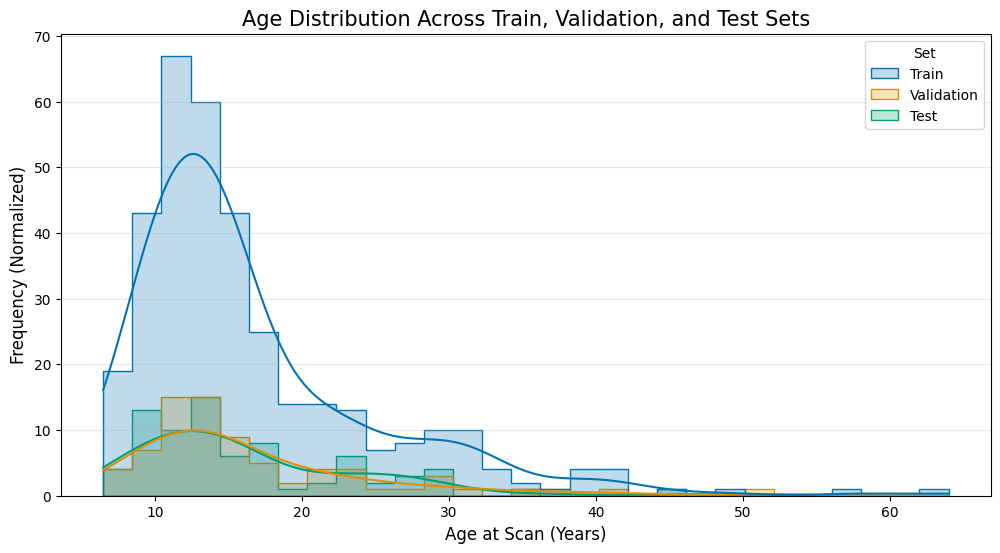

In [ ]:
# Prepare data for visualization
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df['Set'] = 'Train'
val_df['Set'] = 'Validation'
test_df['Set'] = 'Test'

combined_df = pd.concat([train_df, val_df, test_df])

# Plotting
plt.figure(figsize=(12, 6))

# Histogram/KDE plot
sns.histplot(data=combined_df, x='AGE_AT_SCAN', hue='Set', element='step', kde=True, palette='colorblind', common_norm=False)

plt.title('Age Distribution Across Train, Validation, and Test Sets', fontsize=15)
plt.xlabel('Age at Scan (Years)', fontsize=12)
plt.ylabel('Frequency (Normalized)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Summary stats to print
summary_stats = combined_df.groupby('Set')['AGE_AT_SCAN'].agg(['mean', 'std', 'min', 'max', 'count'])
print(summary_stats)

In [ ]:
# Check if balance is maintained (Example for gender)
print("\nGender Distribution (%)")
print("Train:\n", train_df['SEX'].value_counts(normalize=True))
print("Val:\n", val_df['SEX'].value_counts(normalize=True))
print("Test:\n", test_df['SEX'].value_counts(normalize=True))


Gender Distribution (%)
Train:
 SEX
Male      0.823864
Female    0.176136
Name: proportion, dtype: float64
Val:
 SEX
Male      0.8
Female    0.2
Name: proportion, dtype: float64
Test:
 SEX
Male      0.842105
Female    0.157895
Name: proportion, dtype: float64


In [ ]:
# Check if balance is maintained (Example for DX_GROUP)
print("\nDiagnosis Group Distribution (%)")
print("Train:\n", train_df['DX_GROUP'].value_counts(normalize=True))
print("Val:\n", val_df['DX_GROUP'].value_counts(normalize=True))
print("Test:\n", test_df['DX_GROUP'].value_counts(normalize=True))


Diagnosis Group Distribution (%)
Train:
 DX_GROUP
Control    0.551136
Autism     0.448864
Name: proportion, dtype: float64
Val:
 DX_GROUP
Control    0.546667
Autism     0.453333
Name: proportion, dtype: float64
Test:
 DX_GROUP
Control    0.552632
Autism     0.447368
Name: proportion, dtype: float64
